# EXERCISE 11 - Gamma ray bursts

Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
- You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**

## IMPORT MODULES

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform, gaussian_kde
from scipy.optimize import brentq

import sklearn.preprocessing as pp
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [2]:
## --- FUNCTIONS --- ##

def kde_pdf(data, bw, kernel='gaussian', n=1000): # default kernel:gaussian (as in sklearn)
    kde_skl = KernelDensity(bandwidth=bw, kernel=kernel)
    kde_skl.fit(data[:, None])
    
    x = np.linspace(data.min(), data.max(), n)
    log_pdf = kde_skl.score_samples(x[:, None]) # sklearn returns log(density)
    return x, np.exp(log_pdf)

## LOAD DATA

To download the data file (to do only if haven't done already):

    import requests

    r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
    with open("Summary_table.txt", 'wb') as f:
        f.write(r.content)

In [3]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [4]:
## --- REORGANIZING DATA --- ##

# GRB position as (ra, decl, err) [°]
pos = data[3:6].astype(float)

# GRB duration as (t, err) [s]
T90 = data[6:8].astype(float)

# GRB fluence: total energy per unit area as (f, err) [erg/cm^2]
f = data[9:11].astype(float)

# GRB redshift
z = data[11].astype(float)
z = z[z > 0]

# L14:

## Tasks

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

# 1 - DATA EXPLORATION

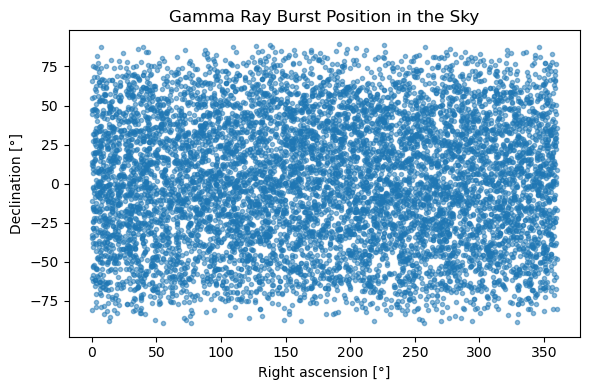

In [5]:
fig, ax = plt.subplots(figsize=(6,4), layout='tight')

ax.scatter(pos[0], pos[1], marker='.', alpha=.5)

ax.set_title('Gamma Ray Burst Position in the Sky')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]');

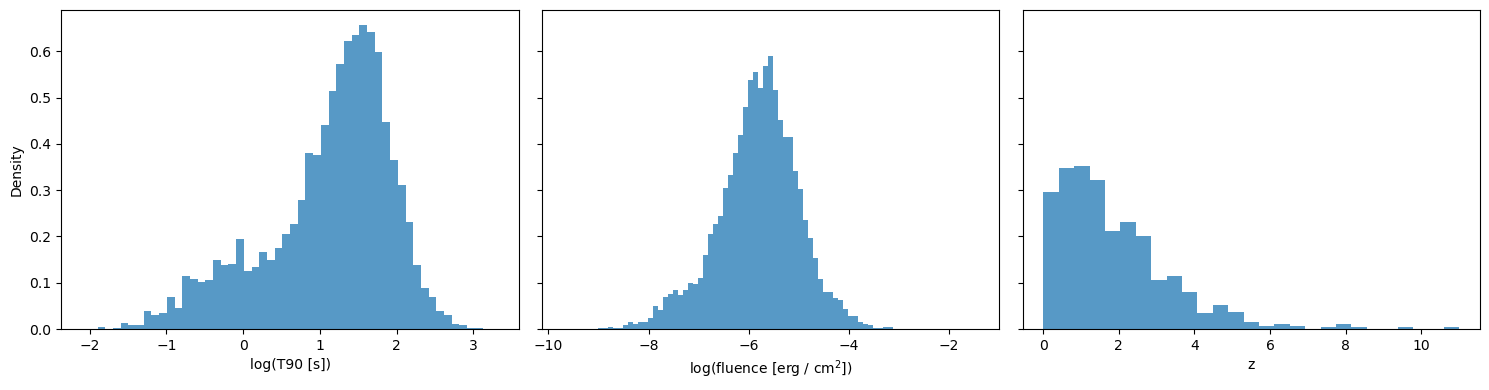

In [6]:
## --- HISTOGRAMS --- ##

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True, layout='tight')

axs[0].hist(np.log10(T90[0][T90[0] > 0]), bins='fd', density=True, alpha=.75)
axs[0].set_xlabel('log(T90 [s])')
axs[0].set_ylabel('Density')

axs[1].hist(np.log10(f[0][f[0] > 0]), bins='fd', density=True, alpha=.75)
axs[1].set_xlabel(r'log(fluence [erg / cm$^2$])')

axs[2].hist(z, bins='fd', density=True, alpha=.75)
axs[2].set_xlabel('z');

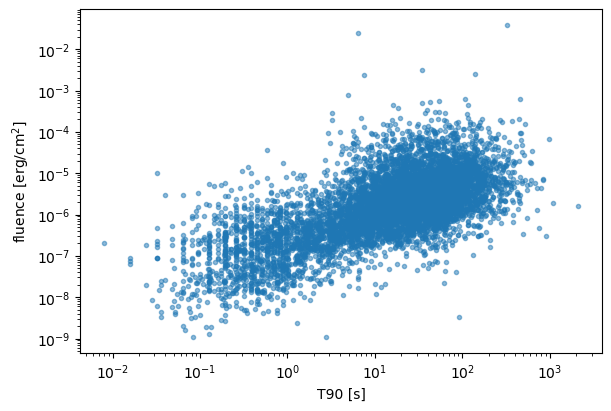

In [7]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

mask = (T90[0] != -999) & (f[0] != -999)

ax.plot(T90[0][mask], f[0][mask], '.', alpha=.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('T90 [s]')
ax.set_ylabel(r'fluence [erg/cm$^2$]');

# 2 - 1D DATA DISTRIBUTIONS

In [8]:
## --- CROSS VALIDATION --- ##

logT90, logf = np.log10(T90[0][T90[0] > 0]), np.log10(f[0][f[0] > 0])

N = 10 # default: 10 parameters iterations
K = 5 # default: 5-folds cross validation

best_bw = np.empty(3)
cv = RandomizedSearchCV(KernelDensity(), {'bandwidth': uniform()}, n_iter=N, cv=K)
for i, x in enumerate([logT90[:, None], logf[:, None], z[:, None]]):
    cv.fit(x)
    
    best_bw[i] = cv.best_params_['bandwidth']

print(' --- Best Bandwidths ---\n')
print(f'log(T90):\t {best_bw[0]:.2f}')
print(f'log(f):\t\t {best_bw[1]:.2f}')
print(f'z:\t\t {best_bw[2]:.2f}')

 --- Best Bandwidths ---

log(T90):	 0.12
log(f):		 0.29
z:		 0.43


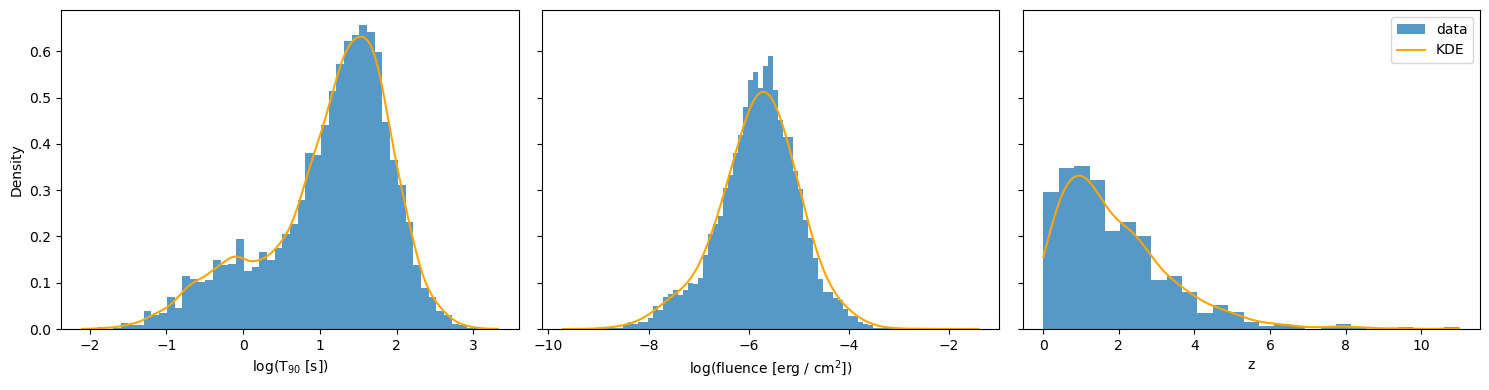

In [9]:
## --- HISTOGRAMS --- ##

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True, layout='tight')

axs[0].hist(logT90, bins='fd', density=True, alpha=.75)
x, y = kde_pdf(logT90, best_bw[0])
axs[0].plot(x, y, color='orange', label='KDE')
axs[0].set_xlabel(r'log(T$_{90}$ [s])')
axs[0].set_ylabel('Density')

axs[1].hist(logf, bins='fd', density=True, alpha=.75)
x, y = kde_pdf(logf, best_bw[1])
axs[1].plot(x, y, color='orange', label='KDE')
axs[1].set_xlabel(r'log(fluence [erg / cm$^2$])')

axs[2].hist(z, bins='fd', density=True, alpha=.75, label='data')
x, y = kde_pdf(z, best_bw[2])
axs[2].plot(x, y, color='orange', label='KDE')
axs[2].set_xlabel('z')
axs[2].legend();

## GaussianMixture

The only 1D distribution clearly showing more than one mode is the log(T$_{90}$) distribution. This is compatible with the distinction in the literature between short and log GRB.

In [10]:
## --- GAUSSIAN MIXTURE --- ##

N = 5

n, model, aic = np.arange(N) + 1, [], np.empty(N)
for i in n:
    m = GaussianMixture(i)
    model.append(m.fit(logT90[:, None]))
    aic[i-1] = m.aic(logT90[:, None])

index = np.argmin(aic)

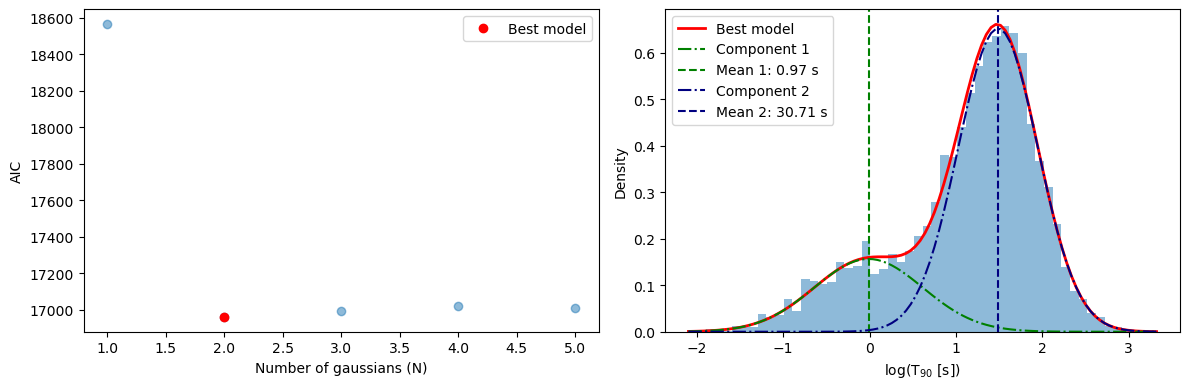

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout='tight')

ax = axs[0]
ax.plot(n, aic, 'o', alpha=.5)
ax.plot(index+1, aic.min(), 'o', color='r', label='Best model')

ax.set_xlabel('Number of gaussians (N)')
ax.set_ylabel('AIC')
ax.legend()

ax = axs[1]
ax.hist(logT90, bins='fd', density=True, alpha=.5)

x = np.linspace(logT90.min(), logT90.max(), 100)
y = np.exp(model[index].score_samples(x[:, None]))
ax.plot(x, y, color='red', lw=2, label='Best model')

resp = model[index].predict_proba(x[:, None])
mean = model[index].means_.flatten()

color = ['green', 'navy']
for i in range(index+1):
    ax.plot(x, resp[:, i] * y, color=color[i], ls='-.', label=f'Component {i+1}')
    ax.axvline(mean[i], color=color[i], ls='--', label=f'Mean {i+1}: {10**mean[i]:.2f} s')

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel('Density')
ax.legend();

## KMeans

In [12]:
## --- KMEANS --- ##

km = KMeans(n_clusters=2, n_init='auto')
km.fit(logT90[:, None])

Y = km.predict(logT90[:, None]) # predict the label of each data point (i.e. to which cluster it belongs to)
centroid = km.cluster_centers_.flatten()

mask = Y == 0 # ~

w_0, kde_0 = logT90[mask].size / logT90.size, gaussian_kde(logT90[mask])
w_1, kde_1 = logT90[~mask].size / logT90.size, gaussian_kde(logT90[~mask])

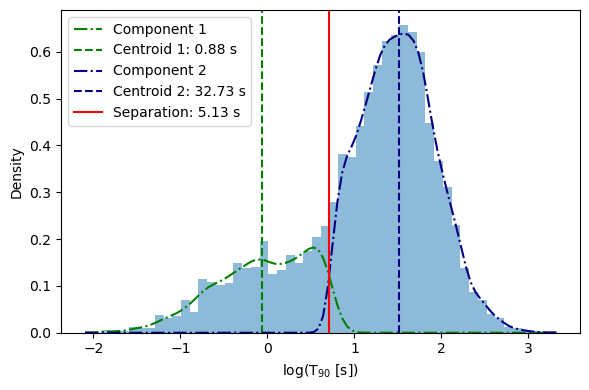

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='tight')

ax.hist(logT90, bins='fd', density=True, alpha=.5)

color = ['green', 'navy']
ax.plot(x, w_0 * kde_0(x), color=color[0], ls='-.', label='Component 1')
ax.axvline(centroid[0], color=color[0], ls='--', label=f'Centroid 1: {10**centroid[0]:.2f} s')

ax.plot(x, w_1 * kde_1(x), color=color[1], ls='-.', label='Component 2')
ax.axvline(centroid[1], color=color[1], ls='--', label=f'Centroid 2: {10**centroid[1]:.2f} s')

def diff(x):
    return w_0 *  kde_0(x) - w_1 * kde_1(x)

sep = brentq(diff, logT90.min(), logT90.max())
ax.axvline(sep, color='r', label=f'Separation: {10**sep:.2f} s')

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel('Density')
ax.legend();

# 3 - 2D DATA DISTRIBUTIONS

In [14]:
# Organize data for sklearn

mask = (T90[0] > 0) & (f[0] > 0)

X = np.column_stack([T90[0][mask], f[0][mask]])
logX = np.log10(X)

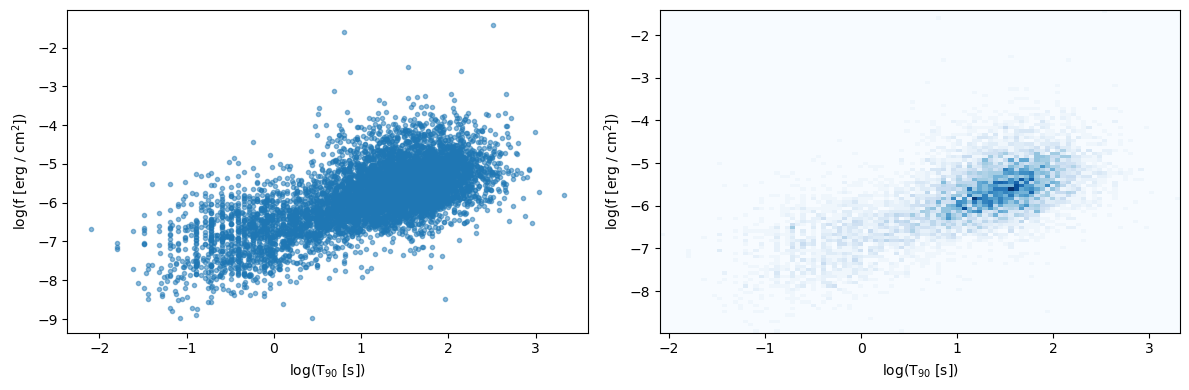

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), layout='tight')

ax = axs[0]
ax.scatter(logX[:, 0], logX[:, 1], marker='.', alpha=.5)

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel(r'log(f [erg / cm$^2$])')

ax = axs[1]
ax.hist2d(logX[:, 0], logX[:, 1], bins=100, density=True, cmap='Blues')

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel(r'log(f [erg / cm$^2$])');

## GaussianMixture

In [16]:
## --- GAUSSIAN MIXTURE --- ##

N = 5

n, model, aic = np.arange(N) + 1, [], np.empty(N)
for i in n:
    m = GaussianMixture(i)
    model.append(m.fit(logX))
    aic[i-1] = m.aic(logX)

index = np.argmin(aic)

Y = model[index].predict(logX)
mean = model[index].means_

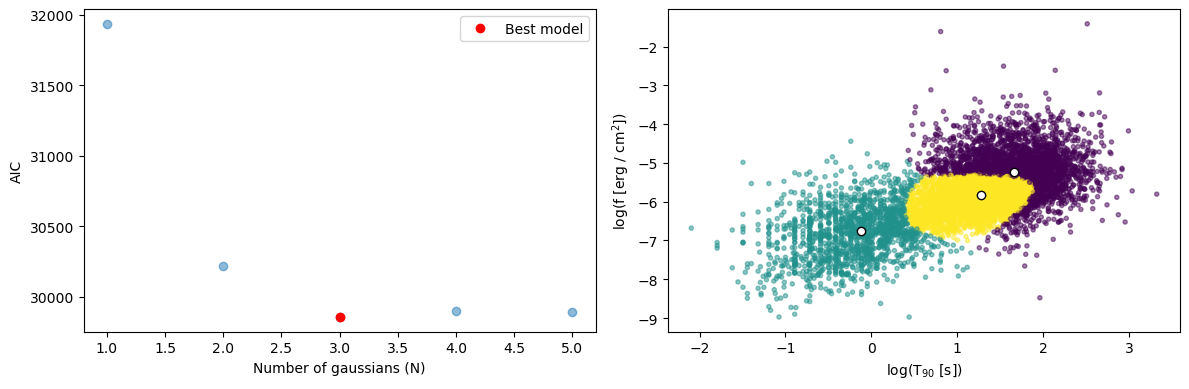

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout='tight')

ax = axs[0]
ax.plot(n, aic, 'o', alpha=.5)
ax.plot(index+1, aic.min(), 'o', color='r', label='Best model')

ax.set_xlabel('Number of gaussians (N)')
ax.set_ylabel('AIC')
ax.legend()

ax = axs[1]
ax.scatter(logX[:, 0], logX[:, 1], c=Y, marker='.', alpha=.5)
ax.scatter(mean[:, 0], mean[:, 1], c='w', edgecolors='k')

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel(r'log(f [erg / cm$^2$])');

## KMeans

In [18]:
## --- KMEANS ALGORITHM --- ##

N = 2

km = KMeans(n_clusters=N, n_init='auto')
km.fit(logX)

Y = km.predict(logX) # labels for each of the points
centroid = km.cluster_centers_ # location of the clusters

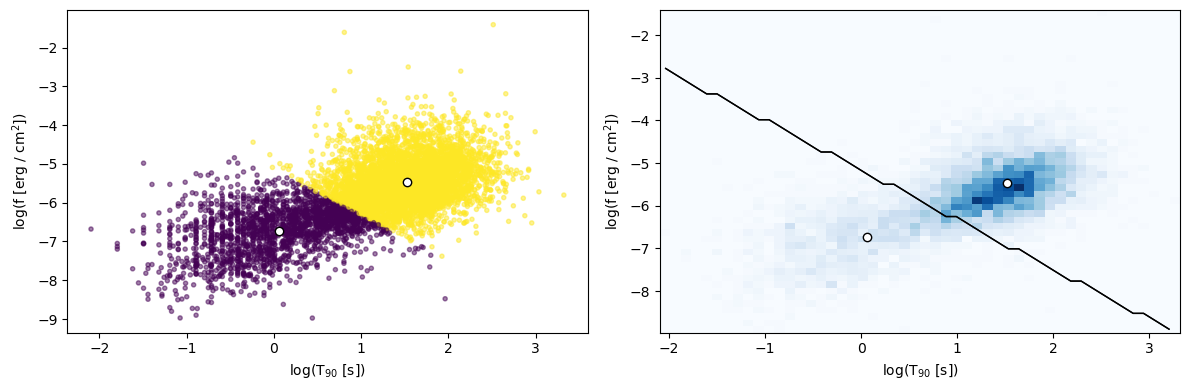

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), layout='tight')

ax = axs[0]
ax.scatter(logX[:, 0], logX[:, 1], c=Y, marker='.', alpha=.5)
    
ax.scatter(centroid[:, 0], centroid[:, 1], c='w', edgecolors='k')

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel(r'log(f [erg / cm$^2$])')

ax = axs[1]
h, xed, yed, im = ax.hist2d(logX[:, 0], logX[:, 1], bins=50, density=True, cmap='Blues')

x_center = .5 * (xed[1:] + xed[:-1])
y_center = .5 * (yed[1:] + yed[:-1])

Xgrid = np.array(np.meshgrid(x_center, y_center))
Z = km.predict(Xgrid.reshape(2, int(Xgrid.size / 2)).T).reshape(x_center.size, y_center.size)

for ii in range(N):
    ax.contour(x_center, y_center, (Z == ii).astype(int), levels=[.5], colors='k', linewidths=1)

ax.scatter(centroid[:, 0], centroid[:, 1], c='w', edgecolors='k')

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel(r'log(f [erg / cm$^2$])');

## MeanShift

In [20]:
## --- MEAN-SHIFT ALGORITHM --- ##

bandwidth = estimate_bandwidth(logX)
print(f'Estimated bandwidth: {bandwidth:.2f}')

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(logX)
centroid = ms.cluster_centers_ # location of the clusters
Y = ms.predict(logX) # labels for each of the points

Estimated bandwidth: 0.92


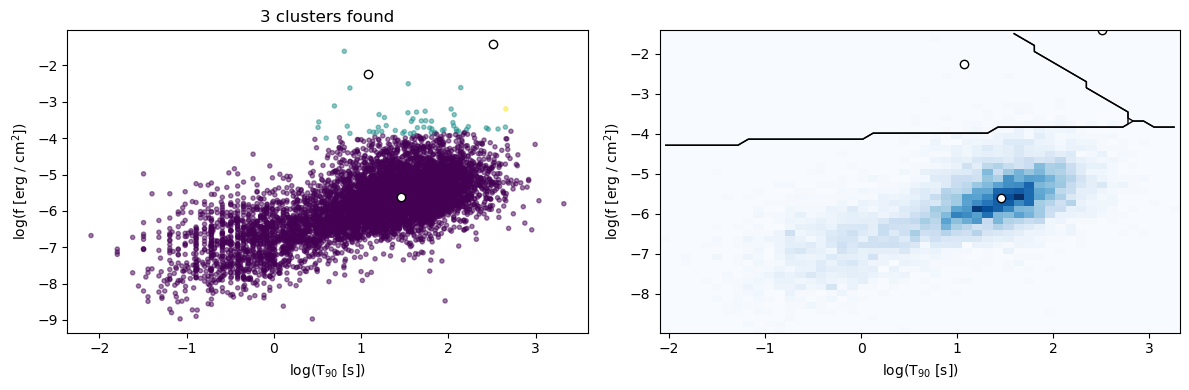

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), layout='tight')

ax = axs[0]
ax.scatter(logX[:, 0], logX[:, 1], c=Y, marker='.', alpha=.5)
    
ax.scatter(centroid[:, 0], centroid[:, 1], c='w', edgecolors='k')

ax.set_title(f'{len(centroid)} clusters found')
ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel(r'log(f [erg / cm$^2$])')

ax = axs[1]
h, xed, yed, im = ax.hist2d(logX[:, 0], logX[:, 1], bins=50, density=True, cmap='Blues')

x_center = .5 * (xed[1:] + xed[:-1])
y_center = .5 * (yed[1:] + yed[:-1])

Xgrid = np.array(np.meshgrid(x_center, y_center))
Z = ms.predict(Xgrid.reshape(2, int(Xgrid.size / 2)).T).reshape(x_center.size, y_center.size)

for ii in range(len(centroid)):
    ax.contour(x_center, y_center, (Z == ii).astype(int), levels=[.5], colors='k', linewidths=1)

ax.scatter(centroid[:, 0], centroid[:, 1], c='w', edgecolors='k')

ax.set_xlabel(r'log(T$_{90}$ [s])')
ax.set_ylabel(r'log(f [erg / cm$^2$])');